<a href="https://colab.research.google.com/github/AhmadAkbariR/deepxde/blob/master/examples/operator/elasticity-2D-AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
# @title Default title text
"""Backend supported: tensorflow, pytorch, paddle"""

import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
current_backend = dde.backend.backend_name
print("Current default backend is:", current_backend)


# PDE equation
def pde(xy, uv, aux):
    mu = 0.01
    nu = 0.3
    u, v = uv[..., 0:1], uv[..., 1:2]
    #u, v, p = uvp[..., 0:1], uvp[..., 1:2], uvp[..., 2:3]
    grad_u = dde.zcs.LazyGrad(xy, u)
    grad_v = dde.zcs.LazyGrad(xy, v)
    #grad_p = dde.zcs.LazyGrad(xy, p)
    # first order
    du_x = grad_u.compute((1, 0))
    dv_y = grad_v.compute((0, 1))
    #dp_x = grad_p.compute((1, 0))
    #dp_y = grad_p.compute((0, 1))
    # second order
    du_xx = grad_u.compute((2, 0))
    du_yy = grad_u.compute((0, 2))
    du_xy = grad_u.compute((1, 1))
    dv_xx = grad_v.compute((2, 0))
    dv_xy = grad_v.compute((1, 1))
    dv_yy = grad_v.compute((0, 2))
    Del2U = du_xx + du_yy + (1+nu)/(1-nu) * (du_xx + dv_xy)
    Del2V = dv_xx + dv_yy + (1+nu)/(1-nu) * (du_xy + dv_yy)

    #motion_x = mu * (du_xx + du_yy) - dp_x
    #motion_y = mu * (dv_xx + dv_yy) - dp_y
    #mass = du_x + dv_y
    #return motion_x, motion_y, mass
    return Del2U, Del2V

# Geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Boundary condition
# other boundary conditions will be enforced by output transform
def bc_slip_top_func(x, aux_var):

    return  dde.backend.as_tensor(0.5 )
bc_slip_top = dde.icbc.DirichletBC(
                                    geom=geom,
                                    func=bc_slip_top_func,
                                    on_boundary=lambda x, on_boundary: np.isclose(x[0], 1.),
                                    component=0)

#def bc_slip_top_func(x, aux_var):
    # using (perturbation / 10 + 1) * x * (1 - x)
#    return (aux_var / 10 + 1.) * dde.backend.as_tensor(x[:, 0:1] * (1 - x[:, 0:1]))
#bc_slip_top = dde.icbc.DirichletBC(
#                                    geom=geom,
#                                    func=bc_slip_top_func,
#                                    on_boundary=lambda x, on_boundary: np.isclose(x[1], 1.),
#                                    component=0)
# PDE object
pde = dde.data.PDE(
    geom,
    pde,
    bcs=[bc_slip_top],
    num_domain=500,
    num_boundary=50,  # sampling a bit more points on boundary (1000 on top bc)
    num_test=100,
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
n_pts_edge = 101  # using the size of true solution, but this is unnecessary
eval_pts = np.linspace(0, 1, num=n_pts_edge)[:, None]
data = dde.zcs.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, num_function=20,
    function_variables=[0], num_test=5, batch_size=10
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [n_pts_edge, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
    num_outputs=2,
    multi_output_strategy="independent"
)

# Output transform for zero boundary conditions
def out_transform(inputs, outputs):
    x, y = inputs[1][:, 0], inputs[1][:, 1]
    # horizontal displacement on left
    u = outputs[:, :, 0] * (x)[None, :]
    # vertical dis on left
    v = outputs[:, :, 1] * (x)[None, :]
    ## pressure on bottom
    #p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v), axis=2)
net.apply_output_transform(out_transform)

# Model
model = dde.zcs.Model(data, net)
model.compile("adam", lr=0.001, decay=("inverse time", 100, 0.5))
losshistory, train_state = model.train(iterations=1000)
dde.utils.plot_loss_history(losshistory)
# save model if needed
# model.save('stokes_weights')

# Evaluation
func_feats = func_space.random(1)
v = func_space.eval_batch(func_feats, eval_pts)
v[:] = 0.  # true solution uses zero perturbation
xv, yv = np.meshgrid(eval_pts[:, 0], eval_pts[:, 0], indexing='ij')
xy = np.vstack((np.ravel(xv), np.ravel(yv))).T
sol_pred = model.predict((v, xy))[0]
#sol_true = np.load('../dataset/stokes.npz')['arr_0']
#print('Error on horizontal velocity:', dde.metrics.l2_relative_error(sol_true[:, 0], sol_pred[:, 0]))
#print('Error on vertical velocity:', dde.metrics.l2_relative_error(sol_true[:, 1], sol_pred[:, 1]))
#print('Error on pressure:', dde.metrics.l2_relative_error(sol_true[:, 2], sol_pred[:, 2]))

def deform_coord(xy , sol_pred):

    return xy + sol_pred
deformed = deform_coord(xy , sol_pred)
plt.scatter(deformed[:,0],deformed[:,1])
plt.show()


Current default backend is: pytorch
Compiling model...
'compile' took 0.002647 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.62e+01, 3.81e+00, 9.54e-01]    [2.03e+01, 2.84e+00, 1.82e+00]    []  


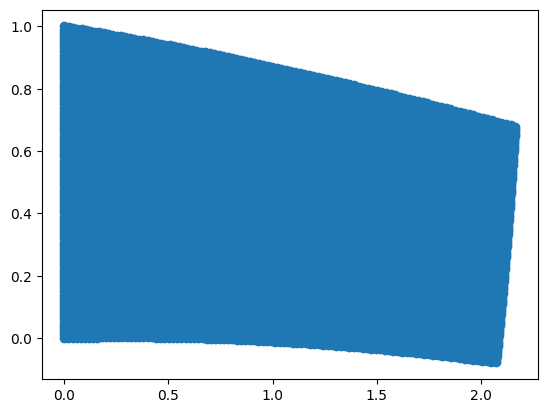

In [ ]:
def deform_coord(xy , sol_pred):

    return xy + sol_pred
deformed = deform_coord(xy , sol_pred)
plt.scatter(deformed[:,0],deformed[:,1])
plt.show()

In [ ]:
# Plot
def plot_sol(sol, ax, pressure_lim=0.03, vec_space=4, vec_scale=.5, label=""):
    ax.imshow(sol[:, :, 2].T, origin="lower",
              vmin=-pressure_lim, vmax=pressure_lim, cmap="turbo", alpha=.6)
    ax.quiver(xv[::vec_space, ::vec_space] * 100,
              yv[::vec_space, ::vec_space] * 100,
              sol[::vec_space, ::vec_space, 0],
              sol[::vec_space, ::vec_space, 1], color="k", scale=vec_scale)
    ax.axis('off')
    ax.set_title(label)

fig, ax = plt.subplots(1, 2, dpi=200)
plot_sol(sol_true.reshape(101, 101, 3), ax[0], label="True")
plot_sol(sol_pred.reshape(101, 101, 3), ax[1], label="Predicted")
# save plot if needed
# plt.savefig('stokes_plot.png')
plt.show()

In [ ]:
def Deformed_shape(xy, uv ):

x = xy[:,0]  # Original x coordinates
y = xy[:,1]  # Original y coordinates
u = uv[:,0]  # Random displacement in x direction
v = uv[:,1]  # Random displacement in y direction


# New coordinates after displacement

x_new = x + u
y_new = y + v

# Plotting
plt.figure(figsize=(12, 8))
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5, label='Displacement (u, v)')
plt.scatter(x, y, color='red', s=10, alpha=0.7, label='Original Nodes')
plt.scatter(x_new, y_new, color='green', s=10, alpha=0.7, label='New Nodes')

# Setting the limits for better visualization
plt.xlim(-0.1, 2.1)  # Adjust the range based on your data
plt.ylim(-0.1, 1.1)
plt.grid()
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.title('Original and Displaced Nodes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()